In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [04:31:15] Enabling RDKit 2019.09.3 jupyter extensions
[04:31:15] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [3]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

number of all smiles:  1513


number of successfully processed smiles:  1513


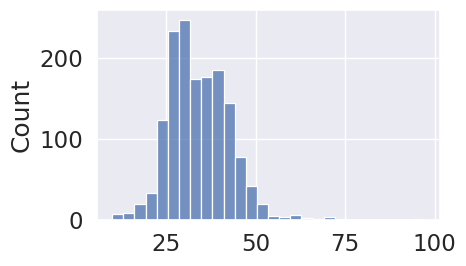

In [4]:
task_name = 'BACE'
tasks = ['Class']
raw_filename = "../data/bace.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.mol.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["mol"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [5]:
random_seed = 88
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.1
fingerprint_dim = 150

radius = 3
T = 2
weight_decay = 2.9 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
# smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]
# uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>150]

# smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

feature dicts file saved as ../data/bace.pickle


,mol,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID,cano_smiles


In [7]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["mol",task]]
    positive_df = remained_df[remained_df[task] == 1][["mol",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [8]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

649206
atom_fc.weight torch.Size([150, 39])
atom_fc.bias torch.Size([150])
neighbor_fc.weight torch.Size([150, 49])
neighbor_fc.bias torch.Size([150])
GRUCell.0.weight_ih torch.Size([450, 150])
GRUCell.0.weight_hh torch.Size([450, 150])
GRUCell.0.bias_ih torch.Size([450])
GRUCell.0.bias_hh torch.Size([450])
GRUCell.1.weight_ih torch.Size([450, 150])
GRUCell.1.weight_hh torch.Size([450, 150])
GRUCell.1.bias_ih torch.Size([450])
GRUCell.1.bias_hh torch.Size([450])
GRUCell.2.weight_ih torch.Size([450, 150])
GRUCell.2.weight_hh torch.Size([450, 150])
GRUCell.2.bias_ih torch.Size([450])
GRUCell.2.bias_hh torch.Size([450])
align.0.weight torch.Size([1, 300])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 300])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 300])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([150, 150])
attend.0.bias torch.Size([150])
attend.1.weight torch.Size([150, 150])
attend.1.bias torch.Size([150])
attend.2.weight torch.Size([150, 150])

In [9]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(len(tasks)):
        y_val_list[i] = []
        y_pred_list[i] = []
    
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
        
            y_val_list[i].extend(y_val_adjust)
            y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall, 


In [10]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.85:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
#         +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
#         +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
        break
        
    torch.manual_seed(epoch)    
    train(model, train_df, optimizer, loss_function)


EPOCH:	0
train_roc:[0.6732848605029056]
valid_roc:[0.6295774647887323]



EPOCH:	1
train_roc:[0.6767220248423256]
valid_roc:[0.6107394366197184]



EPOCH:	2
train_roc:[0.6893566333415958]
valid_roc:[0.6320422535211268]



EPOCH:	3
train_roc:[0.6940923737916219]
valid_roc:[0.6338028169014085]



EPOCH:	4
train_roc:[0.6974909801977471]
valid_roc:[0.6376760563380282]



EPOCH:	5
train_roc:[0.7007023052135833]
valid_roc:[0.6411971830985915]



EPOCH:	6
train_roc:[0.7075766338924233]
valid_roc:[0.6475352112676057]



EPOCH:	7
train_roc:[0.7142636811809744]
valid_roc:[0.6485915492957747]



EPOCH:	8
train_roc:[0.7244099259136854]
valid_roc:[0.6563380281690141]



EPOCH:	9
train_roc:[0.7350904734363382]
valid_roc:[0.6695422535211267]



EPOCH:	10
train_roc:[0.7468396265388746]
valid_roc:[0.6788732394366197]



EPOCH:	11
train_roc:[0.7443471315651766]
valid_roc:[0.6792253521126761]



EPOCH:	12
train_roc:[0.7494174997934396]
valid_roc:[0.6838028169014084]



EPOCH:	13
train_roc:[0.7494477953124571]
valid_roc:[0.6827464788732394]



EPOCH:	14
train_roc:[0.7561775317414415]
valid_roc:[0.6920774647887324]



EPOCH:	15
train_roc:[0.7629843840370156]
valid_roc:[0.7024647887323944]



EPOCH:	16
train_roc:[0.7692610647497866]
valid_roc:[0.7191901408450704]



EPOCH:	17
train_roc:[0.7705968217246412]
valid_roc:[0.7161971830985916]



EPOCH:	18
train_roc:[0.771169682447878]
valid_roc:[0.7153169014084507]



EPOCH:	19
train_roc:[0.7761973615357074]
valid_roc:[0.7211267605633802]



EPOCH:	20
train_roc:[0.7797791181249828]
valid_roc:[0.7286971830985914]



EPOCH:	21
train_roc:[0.7816657027183342]
valid_roc:[0.7279929577464789]



EPOCH:	22
train_roc:[0.7843812828775235]
valid_roc:[0.7306338028169015]



EPOCH:	23
train_roc:[0.7878597592883309]
valid_roc:[0.7419014084507042]



EPOCH:	24
train_roc:[0.7906579635902946]
valid_roc:[0.7424295774647888]



EPOCH:	25
train_roc:[0.7866066264562506]
valid_roc:[0.7295774647887324]



EPOCH:	26
train_roc:[0.7906662260045718]
valid_roc:[0.7378521126760563]



EPOCH:	27
train_roc:[0.7966812635985568]
valid_roc:[0.7477112676056339]



EPOCH:	28
train_roc:[0.8001487234569942]
valid_roc:[0.7544014084507042]



EPOCH:	29
train_roc:[0.8000440662094799]
valid_roc:[0.7496478873239437]



EPOCH:	30
train_roc:[0.8011705086893056]
valid_roc:[0.7508802816901409]



EPOCH:	31
train_roc:[0.8030543391445648]
valid_roc:[0.7538732394366198]



EPOCH:	32
train_roc:[0.8059516924178578]
valid_roc:[0.7577464788732395]



EPOCH:	33
train_roc:[0.8092263626098213]
valid_roc:[0.7621478873239436]



EPOCH:	34
train_roc:[0.8117271199977968]
valid_roc:[0.7646126760563381]



EPOCH:	35
train_roc:[0.814893001735107]
valid_roc:[0.7697183098591548]



EPOCH:	36
train_roc:[0.81844997108155]
valid_roc:[0.7704225352112676]



EPOCH:	37
train_roc:[0.8217742157591781]
valid_roc:[0.7841549295774649]



EPOCH:	38
train_roc:[0.8249277038750723]
valid_roc:[0.782218309859155]



EPOCH:	39
train_roc:[0.8281335206147236]
valid_roc:[0.7846830985915493]



EPOCH:	40
train_roc:[0.8302321738411964]
valid_roc:[0.7860915492957746]



EPOCH:	41
train_roc:[0.8323335812057616]
valid_roc:[0.7929577464788732]



EPOCH:	42
train_roc:[0.8340962295849514]
valid_roc:[0.7941901408450703]



EPOCH:	43
train_roc:[0.8368145638822331]
valid_roc:[0.7992957746478874]



EPOCH:	44
train_roc:[0.8386570822661048]
valid_roc:[0.8003521126760563]



EPOCH:	45
train_roc:[0.8405216337547163]
valid_roc:[0.8007042253521127]



EPOCH:	46
train_roc:[0.841884932110496]
valid_roc:[0.7982394366197184]



EPOCH:	47
train_roc:[0.8434988570326916]
valid_roc:[0.8012323943661973]



EPOCH:	48
train_roc:[0.8450521909168527]
valid_roc:[0.803169014084507]



EPOCH:	49
train_roc:[0.8435401691040789]
valid_roc:[0.8024647887323942]



EPOCH:	50
train_roc:[0.8428681594095129]
valid_roc:[0.8005281690140845]



EPOCH:	51
train_roc:[0.8463824396155223]
valid_roc:[0.8068661971830985]



EPOCH:	52
train_roc:[0.8478586576330938]
valid_roc:[0.8109154929577465]



EPOCH:	53
train_roc:[0.8507174529730921]
valid_roc:[0.813732394366197]



EPOCH:	54
train_roc:[0.8529951251755763]
valid_roc:[0.8110915492957745]



EPOCH:	55
train_roc:[0.854251012145749]
valid_roc:[0.8139084507042254]



EPOCH:	56
train_roc:[0.8558401498251123]
valid_roc:[0.8139084507042254]



EPOCH:	57
train_roc:[0.8533545401966455]
valid_roc:[0.8047535211267606]



EPOCH:	58
train_roc:[0.8555509653254015]
valid_roc:[0.8121478873239437]



EPOCH:	59
train_roc:[0.8575449613043599]
valid_roc:[0.8197183098591548]



EPOCH:	60
train_roc:[0.8584097606653999]
valid_roc:[0.8193661971830987]



EPOCH:	61
train_roc:[0.8606736621774214]
valid_roc:[0.8304577464788733]



EPOCH:	62
train_roc:[0.8613401635958028]
valid_roc:[0.8336267605633803]



EPOCH:	63
train_roc:[0.8622104712330276]
valid_roc:[0.8294014084507042]



EPOCH:	64
train_roc:[0.8637252471838938]
valid_roc:[0.826056338028169]



EPOCH:	65
train_roc:[0.8652097276157427]
valid_roc:[0.834330985915493]



EPOCH:	66
train_roc:[0.8655264534963782]
valid_roc:[0.8286971830985915]



EPOCH:	67
train_roc:[0.8652758269299624]
valid_roc:[0.8294014084507042]



EPOCH:	68
train_roc:[0.8673882508468975]
valid_roc:[0.8301056338028169]



EPOCH:	69
train_roc:[0.8681731802032553]
valid_roc:[0.8294014084507042]



EPOCH:	70
train_roc:[0.8699743865157398]
valid_roc:[0.8242957746478873]



EPOCH:	71
train_roc:[0.8716709355807102]
valid_roc:[0.834330985915493]



EPOCH:	72
train_roc:[0.8714753917761437]
valid_roc:[0.8346830985915493]



EPOCH:	73
train_roc:[0.8730590211793219]
valid_roc:[0.8343309859154929]



EPOCH:	74
train_roc:[0.8739265746784544]
valid_roc:[0.833274647887324]



EPOCH:	75
train_roc:[0.8756424027100719]
valid_roc:[0.8401408450704225]



EPOCH:	76
train_roc:[0.876917568646892]
valid_roc:[0.8417253521126761]



EPOCH:	77
train_roc:[0.8785672973642898]
valid_roc:[0.8431338028169014]



EPOCH:	78
train_roc:[0.8791374039494341]
valid_roc:[0.8436619718309859]



EPOCH:	79
train_roc:[0.8778952876697238]
valid_roc:[0.8390845070422535]



EPOCH:	80
train_roc:[0.8805282436861385]
valid_roc:[0.8427816901408451]



EPOCH:	81
train_roc:[0.8818199344515134]
valid_roc:[0.8519366197183099]



EPOCH:	82
train_roc:[0.8822661048224958]
valid_roc:[0.8471830985915493]



EPOCH:	83
train_roc:[0.8748216695585116]
valid_roc:[0.8352112676056339]



EPOCH:	84
train_roc:[0.8782450632074694]
valid_roc:[0.8422535211267606]



EPOCH:	85
train_roc:[0.8795312456966593]
valid_roc:[0.8396126760563379]



EPOCH:	86
train_roc:[0.8800352529675838]
valid_roc:[0.8413732394366197]



EPOCH:	87
train_roc:[0.8828885400313972]
valid_roc:[0.8459507042253521]



EPOCH:	88
train_roc:[0.8841444270015699]
valid_roc:[0.8433098591549296]



EPOCH:	89
train_roc:[0.885493954666887]
valid_roc:[0.8441901408450704]



EPOCH:	90
train_roc:[0.8861962598804705]
valid_roc:[0.8507042253521127]



EPOCH:	91
train_roc:[0.885403068109835]
valid_roc:[0.8463028169014085]



EPOCH:	92
train_roc:[0.8871822413175797]
valid_roc:[0.8528169014084507]



EPOCH:	93
train_roc:[0.8883224544878681]
valid_roc:[0.8496478873239437]



EPOCH:	94
train_roc:[0.8889338731443994]
valid_roc:[0.8517605633802816]



EPOCH:	95
train_roc:[0.8897711311245147]
valid_roc:[0.848943661971831]



EPOCH:	96
train_roc:[0.8899060838910464]
valid_roc:[0.8519366197183098]



EPOCH:	97
train_roc:[0.8907405877330689]
valid_roc:[0.8535211267605635]



EPOCH:	98
train_roc:[0.8917293233082707]
valid_roc:[0.8577464788732395]



EPOCH:	99
train_roc:[0.8930926216640503]
valid_roc:[0.854225352112676]



EPOCH:	100
train_roc:[0.8922608719601202]
valid_roc:[0.8507042253521128]



EPOCH:	101
train_roc:[0.893888567572778]
valid_roc:[0.8549295774647888]



EPOCH:	102
train_roc:[0.8953537690379796]
valid_roc:[0.8563380281690142]



EPOCH:	103
train_roc:[0.8954281307664766]
valid_roc:[0.8570422535211268]



EPOCH:	104
train_roc:[0.8938169599823735]
valid_roc:[0.8482394366197183]



EPOCH:	105
train_roc:[0.8947492357266793]
valid_roc:[0.8554577464788733]



EPOCH:	106
train_roc:[0.8964223746178633]
valid_roc:[0.8584507042253521]



EPOCH:	107
train_roc:[0.8955438045663608]
valid_roc:[0.8556338028169014]



EPOCH:	108
train_roc:[0.8976149164119089]
valid_roc:[0.8619718309859156]



EPOCH:	109
train_roc:[0.8976534743452036]
valid_roc:[0.8561619718309859]



EPOCH:	110
train_roc:[0.8972045498361287]
valid_roc:[0.8552816901408451]



EPOCH:	111
train_roc:[0.8978682971164175]
valid_roc:[0.8579225352112676]



EPOCH:	112
train_roc:[0.8961386983943375]
valid_roc:[0.8448943661971832]



EPOCH:	113
train_roc:[0.8996557327384395]
valid_roc:[0.8487676056338028]



EPOCH:	114
train_roc:[0.8990030020105207]
valid_roc:[0.8529929577464789]



EPOCH:	115
train_roc:[0.899498746867168]
valid_roc:[0.8524647887323944]



EPOCH:	116
train_roc:[0.9008675534991323]
valid_roc:[0.8591549295774648]



EPOCH:	117
train_roc:[0.901820485279132]
valid_roc:[0.8610915492957746]



EPOCH:	118
train_roc:[0.9026274477402298]
valid_roc:[0.8568661971830986]



EPOCH:	119
train_roc:[0.901644220441213]
valid_roc:[0.8556338028169014]



EPOCH:	120
train_roc:[0.901280674213005]
valid_roc:[0.8630281690140844]



EPOCH:	121
train_roc:[0.9019995042551434]
valid_roc:[0.8670774647887324]



EPOCH:	122
train_roc:[0.9024208873832934]
valid_roc:[0.8598591549295775]



EPOCH:	123
train_roc:[0.9031892919110963]
valid_roc:[0.8558098591549296]



EPOCH:	124
train_roc:[0.9035721171059518]
valid_roc:[0.8623239436619718]



EPOCH:	125
train_roc:[0.9039246467817896]
valid_roc:[0.8663732394366196]



EPOCH:	126
train_roc:[0.9045470819906911]
valid_roc:[0.8647887323943662]



EPOCH:	127
train_roc:[0.9051970585805171]
valid_roc:[0.858274647887324]



EPOCH:	128
train_roc:[0.904962956842656]
valid_roc:[0.8558098591549295]



EPOCH:	129
train_roc:[0.9054146354898234]
valid_roc:[0.856161971830986]



EPOCH:	130
train_roc:[0.9062904514032333]
valid_roc:[0.8519366197183098]



EPOCH:	131
train_roc:[0.9058580517227133]
valid_roc:[0.8579225352112676]



EPOCH:	132
train_roc:[0.907130463521441]
valid_roc:[0.8566901408450704]



EPOCH:	133
train_roc:[0.907102922140516]
valid_roc:[0.8565140845070423]



EPOCH:	134
train_roc:[0.9057919524084936]
valid_roc:[0.8433098591549296]



EPOCH:	135
train_roc:[0.9085020242914981]
valid_roc:[0.8522887323943662]



EPOCH:	136
train_roc:[0.9071414800738108]
valid_roc:[0.8489436619718309]



EPOCH:	137
train_roc:[0.907546338373406]
valid_roc:[0.8528169014084507]



EPOCH:	138
train_roc:[0.9092070836431738]
valid_roc:[0.8573943661971831]



EPOCH:	139
train_roc:[0.9078189980445619]
valid_roc:[0.8533450704225353]



EPOCH:	140
train_roc:[0.9051970585805172]
valid_roc:[0.8540492957746479]



EPOCH:	141
train_roc:[0.9067641631551406]
valid_roc:[0.8607394366197183]



EPOCH:	142
train_roc:[0.9093392822716131]
valid_roc:[0.8610915492957748]



EPOCH:	143
train_roc:[0.9091492467432317]
valid_roc:[0.8617957746478874]



EPOCH:	144
train_roc:[0.9105097909609188]
valid_roc:[0.8588028169014084]



EPOCH:	145
train_roc:[0.9077033242446776]
valid_roc:[0.8507042253521128]



EPOCH:	146
train_roc:[0.9097634195378556]
valid_roc:[0.8559859154929578]



EPOCH:	147
train_roc:[0.9088765870720757]
valid_roc:[0.8658450704225352]



EPOCH:	148
train_roc:[0.9104574623371616]
valid_roc:[0.8580985915492958]



EPOCH:	149
train_roc:[0.9103170012944448]
valid_roc:[0.8609154929577465]



EPOCH:	150
train_roc:[0.9120631248450798]
valid_roc:[0.8570422535211267]



In [11]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features,num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_losses = eval(model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:121
test_roc:[0.8631484794275492]
test_roc_mean: 0.8631484794275492
